<h1 style="text-align: center;">Analyis of Point Production of NBA Players</h1>

# Introduction

Using this dataset of NBA player stats we want to perform a regression analysis of the average mount of points that a player may ahieve based on a variety of datapoints like shooting percentage, height, weight, age, and rebounds. All of these things are factors that where better numbers in each category may contribute to a more successful player.

We want to know if age, height, rebounds, and shooting percentage can contribute to a better individual season by an NBA player. 

To do this, we will use [this dataset](https://www.kaggle.com/datasets/justinas/nba-players-data) from Kaggle. 

# Data Analysis

## Load Libraries

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## Load Dataset

New names:
• `` -> `...1`
Rows: 12305 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): player_name, team_abbreviation, college, country, draft_year, draf...
dbl (14): ...1, age, player_height, player_weight, gp, pts, reb, ast, net_ra...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,player_height,player_weight,pts,reb,ts_pct
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
27,200.66,106.59412,2.6,0.6,0.388
28,177.80,72.57472,2.2,0.4,0.479
23,210.82,129.27372,1.7,0.9,0.539
⋮,⋮,⋮,⋮,⋮,⋮
23,200.66,104.32616,28.4,9.1,0.571
23,210.82,106.59412,11.3,7.0,0.551
28,193.04,99.79024,12.1,3.8,0.540


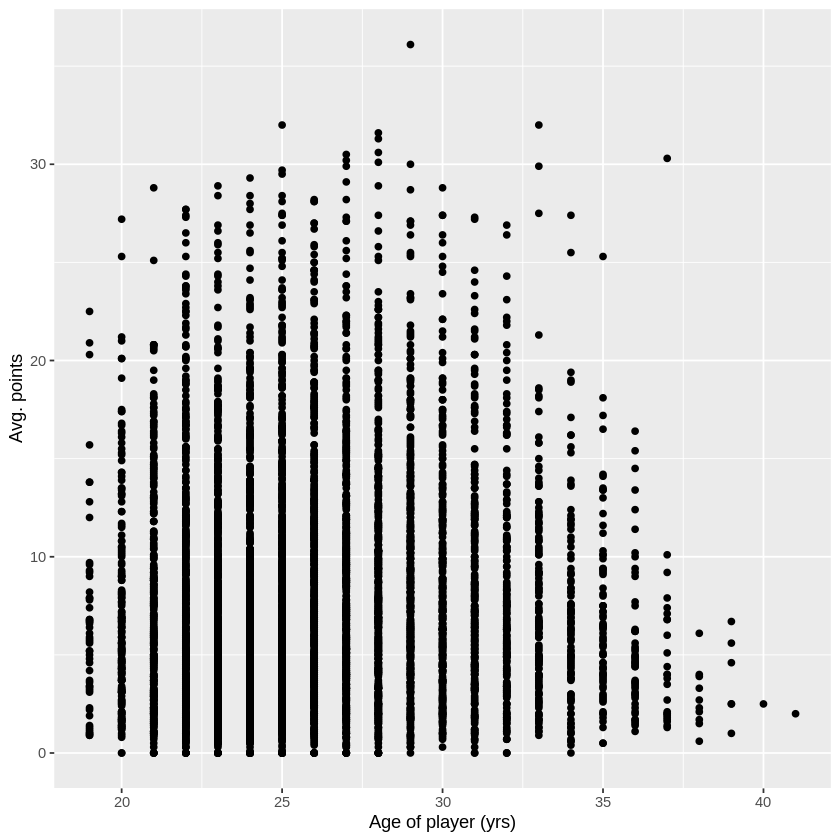

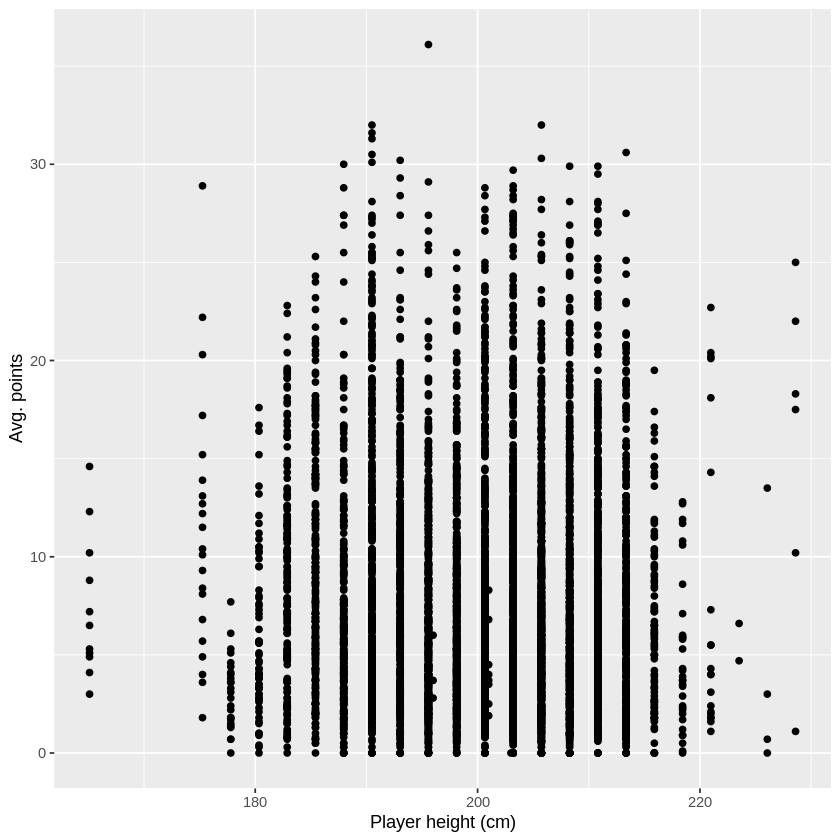

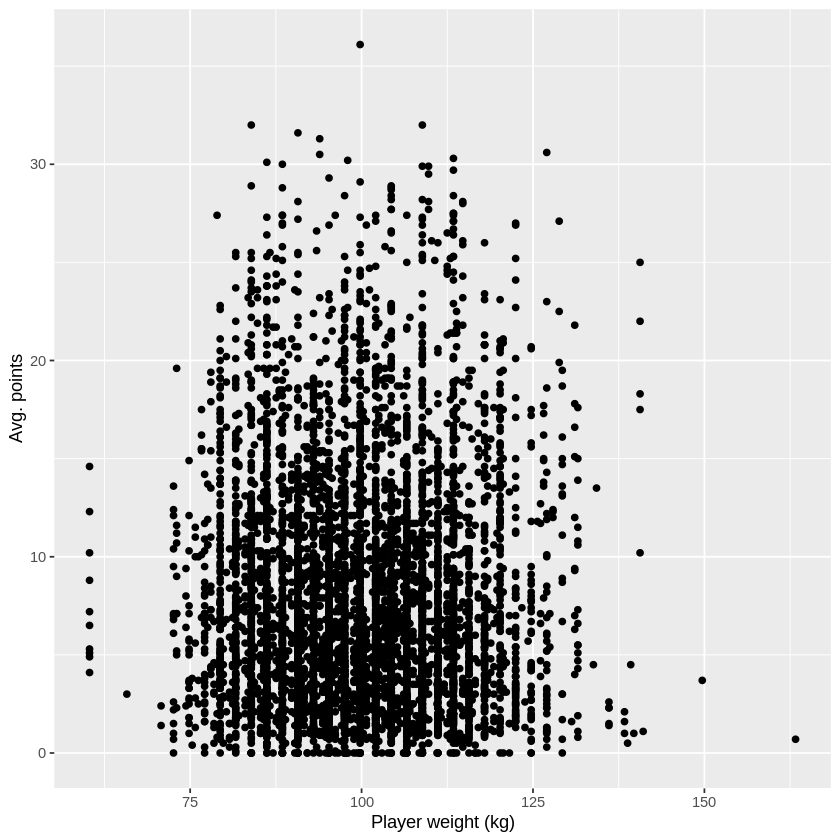

In [11]:
url <-"https://raw.githubusercontent.com/mdean808/dsci-100-group-project/b11c50b091b2c4a554a2b7ff8f9e568e081b0f3c/all_seasons.csv"


temp <- tempfile()


download.file(url, temp)
# read the dataset from temp file
nba_players <- read_csv(temp)

nba_players <- nba_players |>
filter(draft_year > 2000) |>
select(age, player_height, player_weight, pts, reb, ts_pct)

nba_players_split <- initial_split(nba_players, prop = 0.75, strata = pts)
nba_training <- training(nba_players_split)
nba_testing <- testing(nba_players_split)

nba_training


nba_plot_age <- ggplot(nba_training, aes(x = age, y = pts)) +
geom_point() +
labs(x = "Age of player (yrs)", y = "Avg. points")

nba_plot_height <- ggplot(nba_training, aes(x = player_height, y = pts)) +
geom_point() +
labs(x = "Player height (cm)", y = "Avg. points")

nba_plot_weight <- ggplot(nba_training, aes(x = player_weight, y = pts)) +
geom_point() +
labs(x = "Player weight (kg)", y = "Avg. points")

nba_plot_age
nba_plot_height
nba_plot_weight

# Methods

We will conduct analysis on five columns to try and predict the average points a player will get per season using regression analysis. 

`age` (age), `player_height` (height), `reb` (rebounds), and `ts_pct` (shooting percentage)

TODO: does what i'm saying here make any sense? Should we instead put all the datapoints into one number and run a analysis with that number vs the average points?
We will visualize the results using a scatter plot that contains a line of best fit and datapoints for each category compared to the actual points result. By first training a model on the trainnig data and then using the rest of the datapoints for prediction we will attempt to come up with an answer to our question.

# Expected Outcomes and Signifigance

We expect to find that _____________________ will lead to greater points production

These findings could be useful for improving a player's training routine. If a certain factor like an increase in shooting or rebounds increased their overall points total we could suggest that a player change the way they train for an upcoming season.

TODO: what future questions will this lead to?